In [37]:
from obspy import read_events, read_inventory
from obspy.clients.fdsn import Client
from matplotlib import cm
import glob

import numpy as np
from geographiclib.geodesic import Geodesic
from mpl_toolkits.basemap import Basemap
import basemap_circle
from obspy.geodetics import degrees2kilometers
from obspy.geodetics import kilometers2degrees
from obspy import UTCDateTime

import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach

from obspy.geodetics.base import gps2dist_azimuth

In [25]:
from itertools import chain
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

fig = plt.figure(figsize=(8, 6), edgecolor='w', dpi=300)
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )

<Figure size 2400x1800 with 0 Axes>

In [34]:
catlist = read_events('../Data/catalog_array.xml')
inventory = read_inventory("../Data/inventory.xml")
station_latitude_wet = inventory.get_coordinates("GR.WET..HHE")['latitude']
station_longitude_wet = inventory.get_coordinates("GR.WET..HHE")['longitude']
catlist


5 Event(s) in Catalog:
2015-02-11T18:57:27.100000Z | -23.140,  -66.800 | 6.69 Mwc
2021-01-10T03:54:16.900000Z | -24.030,  -66.760 | 6.1  Mwc
2015-03-18T18:27:35.300000Z | -36.160,  -73.900 | 6.12 Mwc
2022-05-10T23:06:36.900000Z | -23.480,  -66.760 | 6.73 Mwc
2015-09-28T15:28:10.000000Z | -23.840,  -66.890 | 5.98 Mwc

In [15]:
SearchCenterLat = -15.9650    # Easter Search Lat -30.192 Lon -110.589; Hawaii Lat 15.4 Lon -172.3;
SearchCenterLon = -5.7089  # Macdonald Search Lat -29 Lon -140.3;

MinRadius = 30  # 30-70 deg affect on the Sdiff path, 40-60 effects are dominant
MaxRadius = 80  # 30-70 deg affect on the Sdiff path, 40-60 effects are dominant
MinDepth = 0  # avoid shallow events for clean stf
MaxDepth = 1000
MinMagnitude = 5.8
MaxMagnitude = 7.0
magnitudetype = 'Mww'
OrderBy = 'time-asc'
StartTime = UTCDateTime("2010-01-01T00:00:00")
EndTime = UTCDateTime.utcnow()

# load IRIS client
irisclient = Client("IRIS") 
multiplecatlist = irisclient.get_events(starttime=StartTime, endtime=EndTime, latitude=SearchCenterLat, longitude=SearchCenterLon,
                            minradius=MinRadius, maxradius=MaxRadius, mindepth=MinDepth, maxdepth=MaxDepth,
                            minmagnitude=MinMagnitude, maxmagnitude=MaxMagnitude, orderby=OrderBy, magnitudetype=magnitudetype) 

/tmp/ipykernel_42126/1832909353.py:10: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  m.scatter(ULVZ_lon,ULVZ_lat,latlon=True,
/home/zhi/anaconda3/lib/python3.8/site-packages/obspy/imaging/beachball.py:186: UserWarning: There is a known bug when plotting semi-transparent patches for non-DC sources, which leads to blending of pressure and tension color, see issue #1464.
  warnings.warn(msg)
/home/zhi/anaconda3/lib/python3.8/site-packages/obspy/imaging/beachball.py:186: UserWarning: There is a known bug when plotting semi-transparent patches for non-DC sources, which leads to blending of pressure and tension color, see issue #1464.
  warnings.warn(msg)
/home/zhi/anaconda3/lib/python3.8/site-packages/obspy/imaging/beachball.py:186: UserWarning: There is a known bug when plotting semi-transparent patches for non-DC sources, which leads to blending 

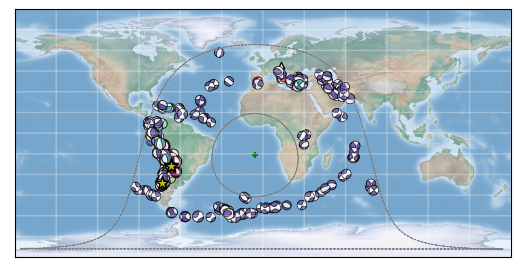

In [33]:
for cat in catlist:
    m.scatter(cat.origins[0].longitude,cat.origins[0].latitude,latlon=True,
    s=100,c='y',marker='*',alpha=1,edgecolors='k',zorder=100)

m.scatter(station_longitude_wet,station_latitude_wet,latlon=True,
    s=20,c='w',marker='^',alpha=1,edgecolors='k')


ULVZ_lat, ULVZ_lon = -15.9650, -5.7089
m.scatter(ULVZ_lon,ULVZ_lat,latlon=True,
    s=20,c='g',marker='+',alpha=1,edgecolors='k')



basemap_circle.equi(m, SearchCenterLon, SearchCenterLat, degrees2kilometers(MinRadius),lw=0.5,color='grey',linestyle='--',zorder=400)
basemap_circle.equi(m, SearchCenterLon, SearchCenterLat, degrees2kilometers(MaxRadius),lw=0.5,color='grey',linestyle='--',zorder=400)


# Define the colormap
Spectral = cm.get_cmap('Spectral',8).reversed()

CMTcatList = glob.glob('/raid1/RingLaser/Data/StHelena/*.CMTSOLUTION')

for CMTcatPath in CMTcatList:

    CMTcat = read_events(CMTcatPath)

    emagtype = CMTcat[0].magnitudes[0].magnitude_type
    emag = CMTcat[0].magnitudes[0].mag
    elat = CMTcat[0].origins[0].latitude
    elon = CMTcat[0].origins[0].longitude
    edepth = CMTcat[0].origins[0].depth/1000
    slat, slon = SearchCenterLat, SearchCenterLon
    mt = CMTcat[0].focal_mechanisms[0].moment_tensor.tensor
    fm = [mt.m_rr, mt.m_tt,mt.m_pp,mt.m_rt,mt.m_rp,mt.m_tp]

    x,y = m(elon,elat)

    color = Spectral(edepth/600)
    ballsize = emag/6.0*350000*0.00002
    beachball = beach(fm, linewidth=0.5, facecolor=color, bgcolor='w', edgecolor='k', alpha=0.85, 
            xy=(x, y), width=ballsize, size=100, nofill=False, zorder=1, axes=None)
    ax = plt.gca()
    ax.add_collection(beachball)


draw_map(m)

In [43]:
SearchAzimuth =  gps2dist_azimuth(-23.140, -66.800, station_latitude_wet, station_longitude_wet)[1]

cat = catlist[0]
EvtLat = cat.origins[0].latitude
EvtLon = cat.origins[0].longitude

distance_m, azimuth, stationazimuth = gps2dist_azimuth(EvtLat, EvtLon, station_latitude_wet, station_longitude_wet)
az = (azimuth + 360)%360
baz = (stationazimuth+ 180)%360
distdg = kilometers2degrees(distance_m/1.0e3)

In [45]:
EvtLat, EvtLon, station_latitude_wet, station_longitude_wet

(-23.11, -66.69, 49.1448, 12.8803)

In [44]:
SearchAzimuth, azimuth, distdg

(41.086571021046204, 41.05434318093723, 100.70479243902668)

In [40]:
from obspy.taup import TauPyModel
phase_list = ['Sdiff','S'] # calculate ref phase time
model = TauPyModel(model='prem')

arrivals = model.get_travel_times(source_depth_in_km=100, 
                distance_in_degree=120, 
                phase_list=phase_list)
phasetime = arrivals[0].time